In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from scipy import interpolate

import math
#from itertools import zip

In [206]:
# Param to calculate Km for a specific stator/winding, function of Temperature
#Resistance
T = [-40, 20, 80, 160] #°C
w = 4E-3 # stator dent[3mm, 4mm]
h = 24E-3
th = 4.67E-3
l = 10.07E-3
sigma = 0.65

# param
Npp = 5

rho = []
for t in T:
    rho.append(1.72E-8*(1 + (t-20)*0.00393))# [-40, 20, 80, 160]°C

R0 = [] # 3mm
for rho_t in rho:
    R0.append(rho_t*(2*(w+h)+math.pi*th)/(sigma*th*l))
    
# Flux
phi_1i2 = [50E-6, 50E-6, 50E-6, 50E-6] # [-40, 20, 80, 160]°C
phi_évidé = [40E-6, 40E-6, 40E-6, 40E-6] # [-40, 20, 80, 160]°C
phi_évidé_l = [40E-6, 40E-6, 40E-6, 40E-6] # [-40, 20, 80, 160]°C

phi = [phi_évidé, phi_1i2, phi_évidé_l]

In [211]:
#R0 evaluation for stator with 3mm teeth or 4mm teeth
T = [-40, 20, 80, 160] #°C
w = np.array([4, 5])*(1E-3) # stator dent[3mm, 4mm]
h = 24*(1E-3)
th = np.array([4.67, 3.71])*(1E-3)
l = np.array([10.07, 10.12])*(1E-3)
sigma = 0.65

R0 = [] # 3mm
R0_4 = [] # 4mm
for rho_t in rho:
    R0.append(rho_t*(2*(w[0]+h)+math.pi*th[0])/(sigma*th[0]*l[0]))
    R0_4.append(rho_t*(2*(w[1]+h)+math.pi*th[1])/(sigma*th[1]*l[1]))
    
print("R0:",R0,'\nR0_4:',R0_4)

R0: [3.038914419436759e-05, 3.9765956810216679e-05, 4.9142769426065773e-05, 6.1645186247197905e-05] 
R0_4: [3.7516466118622491e-05, 4.9092470712670099e-05, 6.0668475306717713e-05, 7.6103148098781177e-05]


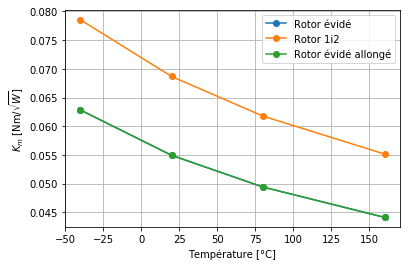

In [212]:
# KM
to_plot = ["Rotor évidé", "Rotor 1i2", "Rotor évidé allongé"]

Km = []
for i, elem_to_plot in enumerate(to_plot):
    Km_rotor = []
    for phi_t, R0_t in zip(phi[i],R0):
        Km_rotor.append(math.sqrt(3)*phi_t*Npp/math.sqrt(R0_t))
    Km.append(Km_rotor)
    plt.plot(T,Km_rotor,'o-',label=elem_to_plot)

plt.xlabel("Température [°C]")
plt.ylabel("$K_m$ [Nm/$\sqrt{W}$]")
plt.legend(loc="best")
#plt.ylim([35,50])
plt.grid()
#plt.savefig("Km_motor"+".pdf")
plt.show()

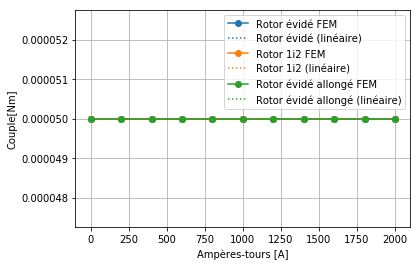

In [213]:
# Torque vs current

I = range(0,2001,200) # Ampere tour
# Couple 20°C
c_1i2 = np.array([50E-6, 50E-6, 50E-6, 50E-6,50E-6, 50E-6, 50E-6, 50E-6,50E-6, 50E-6, 50E-6])
c_évidé = np.array([50E-6, 50E-6, 50E-6, 50E-6,50E-6, 50E-6, 50E-6, 50E-6,50E-6, 50E-6, 50E-6])
c_évidé_l = np.array([50E-6, 50E-6, 50E-6, 50E-6,50E-6, 50E-6, 50E-6, 50E-6,50E-6, 50E-6, 50E-6])

c = [c_évidé, c_1i2, c_évidé_l]


to_plot = ["Rotor évidé", "Rotor 1i2", "Rotor évidé allongé"]
for i, elem_to_plot in enumerate(to_plot):
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(I,c[i], 'o-', color=color,label=elem_to_plot+" FEM")
    plt.plot(I,c[0]+(c[1]-c[0])/(I[1]-I[0])*I,':', color=color, label=elem_to_plot+ " (linéaire)")

plt.xlabel("Ampères-tours [A]")
plt.ylabel("Couple[Nm]")
plt.legend(loc="best")
#plt.ylim([35,50])
plt.grid()
#plt.savefig("Km_motor"+".pdf")
plt.show()

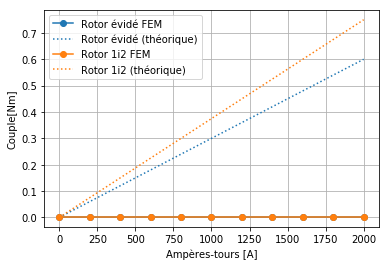

In [102]:
# Torque vs current (FEM vs Torque=phi)
to_plot = ["Rotor évidé", "Rotor 1i2"]
for i, elem_to_plot in enumerate(to_plot):
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(I,c[i], 'o-', color=color,label=elem_to_plot+" FEM")
    plt.plot(I,3/2*Npp*phi[i][1]*np.array(I),':', color=color, label=elem_to_plot+ " (théorique)")

plt.xlabel("Ampères-tours [A]")
plt.ylabel("Couple[Nm]")
plt.legend(loc="best")
#plt.ylim([35,50])
plt.grid()
#plt.savefig("Km_motor"+".pdf")
plt.show()

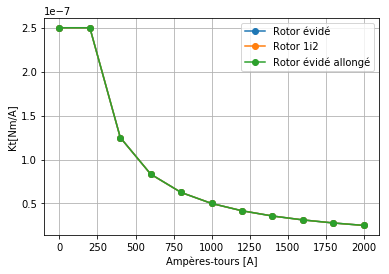

In [214]:
# Kt FEM
to_plot = ["Rotor évidé", "Rotor 1i2", "Rotor évidé allongé"]

for i, elem_to_plot in enumerate(to_plot):
    plt.plot(I,np.concatenate(([c[1][1]/I[1]], (c[1][1:]/I[1:]))),'o-',label=elem_to_plot)

plt.xlabel("Ampères-tours [A]")
plt.ylabel("Kt[Nm/A]")
plt.legend(loc="best")
#plt.ylim([35,50])
plt.grid()
#plt.savefig("Km_motor"+".pdf")
plt.show()

In [ ]:
# Pertes


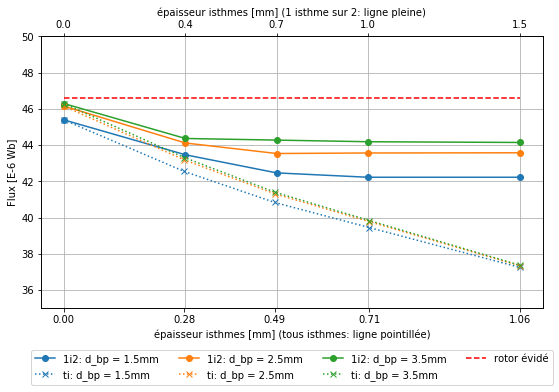

In [744]:
#plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(9,5))

box = ax.get_position()
ax.set_position([box.x0, box.y0+0.05, box.width, box.height])

newax = ax.twiny()
newax.set_position([box.x0, box.y0+0.05, box.width, box.height])

# Make some room at the bottom
#fig.subplots_adjust(bottom=0.20)

# I'm guessing you want them both on the bottom...
ax.set_frame_on(True)
ax.patch.set_visible(False)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

newax.set_frame_on(True)
newax.patch.set_visible(False)
newax.xaxis.set_ticks_position('bottom')
newax.xaxis.set_label_position('bottom')
#newax.spines['top'].set_position(('outward', 40))

lines = []
legends = []
for j in range(1,len(d_bp)-1):
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    
    ax.plot(ei_1i2,df_1i2.iloc[j,:],"o-",color=color, label = "1i2: d_bp = "+str(d_bp[j])+"mm")
    ax.plot([],[],"x:",color=color, label = "ti: d_bp = "+str(d_bp[j])+"mm") # bricolé pour legend
    newax.plot(ei_intp,df_ti_ip.iloc[j,:],"x:",color=color, label = "ti: d_bp = "+str(d_bp[j])+"mm")

ax.plot(ei_1i2,np.ones([len(ei_1i2)])*46.58,"--", color ="red", label= "rotor évidé")   
    
ax.xaxis.set_ticks(ei_1i2)
newax.xaxis.set_ticks(ei_intp)

ax.set_xlabel("épaisseur isthmes [mm] (1 isthme sur 2: ligne pleine)")
newax.set_xlabel("épaisseur isthmes [mm] (tous isthmes: ligne pointillée)") 
ax.set_ylabel("Flux [E-6 Wb]")


ax.legend(loc = "lower center",bbox_to_anchor=(0.5, -.3), ncol=4)
#ax.legend(loc = "best", ncol=4)

#plt.title("Comparaison 1 isthme sur 2 avec tous isthmes")
plt.ylim([35,50])
ax.grid()
plt.savefig("Flux_comparaison_ti_1i2.pdf", bbox_inches = "tight", pad_inches = 0.1)
plt.show()

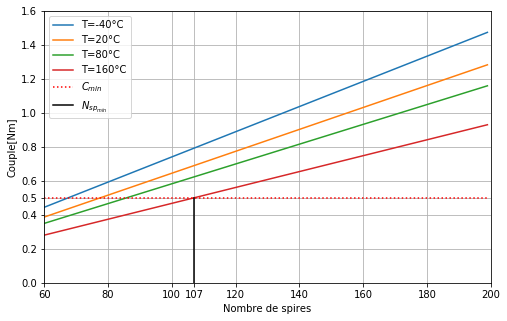

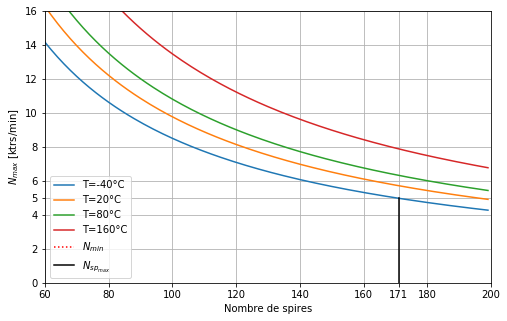

In [123]:
phi_m  = np.array([49.39, 42.99, 38.85, 31.17])*1E-6# Flux moyen évidé en fonction de la température 
Nsp = np.array(range(60,200))
Npp = 5
Imax = 20
U = 22 #alim 24V - pertes?

to_plot = ["-40", "20", "80", "160"] # Temperatures °C

T = [] # Torque
N = [] # Max_speed
plt.figure("T",figsize=(8,5)) # torque plot
plt.figure("N",figsize=(8,5)) # speed plot
for i,elem_to_plot in enumerate(to_plot):
    T.append(3/2*Nsp*Npp*phi_m[i]*Imax) # Torque formula
    N.append(30*U/(Nsp*Npp*phi_m[i]*math.pi)) # Max speed formula
    
    plt.figure("T") # switch plot
    plt.plot(Nsp,T[i],label="T=%s°C"%(elem_to_plot))

    plt.figure("N") # switch plot
    plt.plot(Nsp,N[i]/1000,label="T=%s°C"%(elem_to_plot))


#plot settings for torque
plt.figure("T")
plt.plot(Nsp,np.ones((len(Nsp),1))*0.5,"r:",label="$C_{min}$")

Nsp_min_pos = np.argmax(T[-1]>0.5)
plt.plot([Nsp[Nsp_min_pos], Nsp[Nsp_min_pos]],[0, T[-1][Nsp_min_pos]],"k",label="$N_{sp_{min}}$")

plt.xlim([60,Nsp.max()])
plt.ylim(bottom=0)
plt.xticks(list(plt.xticks()[0])+[Nsp[Nsp_min_pos]])
plt.yticks(list(plt.yticks()[0])+[0.5])
plt.xlabel("Nombre de spires")
plt.ylabel("Couple[Nm]")

plt.legend(loc="best")
plt.grid()
plt.savefig("Nsp_torque.pdf")

# Plot settings for max speed
plt.figure("N")
plt.plot(Nsp,np.ones((len(Nsp),1))*5000,"r:",label="$N_{min}$")

Nsp_max_pos = np.argmax(N[0]<5000)
plt.plot([Nsp[Nsp_max_pos], Nsp[Nsp_max_pos]],[0, N[0][Nsp_max_pos]/1000],"k",label="$N_{sp_{max}}$")

plt.xlim([60,Nsp.max()])
plt.ylim([0,15])
plt.xticks(list(plt.xticks()[0])+[Nsp[Nsp_max_pos]])
plt.yticks(list(plt.yticks()[0])+[5])
plt.xlabel("Nombre de spires")
plt.ylabel("$N_{max}$ [ktrs/min]")

plt.legend(loc="lower left")
plt.grid()
plt.savefig("Nsp_speed.pdf")

plt.show()